- EfficientnetB1
- image size: 1536
- 4 transforms
- val transform in predict

In [1]:
DEBUG = True

In [2]:
import numpy as np
import pandas as pd
import os, random, glob, cv2, gc
from PIL import Image, ImageChops
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from termcolor import colored

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from functools import partial
import scipy as sp
from PIL import Image
import skimage.io
import sys
import albumentations as A
import openslide

In [3]:
torch.cuda.empty_cache()
gc.collect()

50

In [4]:
GRAY_TR = 235
N_TR = 0.85
WHITE_TR = 0.95
V = 1

In [5]:
class config:
    IMG_SIZE = 1536
    BS = 1
    SZ = 256    # not used, just to declare start point, 
    N = 36      # not used, just to declare start point, 
    LEVEL = 1   # not used, just to declare start point,

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [7]:
# get image_folder and df

COMP_DIR = '../input/prostate-cancer-grade-assessment/'
is_test = os.path.exists(COMP_DIR + 'test_images/')

image_folder = COMP_DIR + 'test_images/' if is_test else COMP_DIR + 'train_images/'
df = pd.read_csv(COMP_DIR + 'test.csv' if is_test else COMP_DIR + 'train.csv')

if not is_test:
    if DEBUG:
        df = df.iloc[:30]
    else:
        df = df.iloc[:1000]
        
print(is_test, image_folder, len(df))
display(df.head())

False ../input/prostate-cancer-grade-assessment/train_images/ 30


,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


# Dataset

In [8]:
def get_level(path):
    '''
    openslide is more stable
    Arg
        path: str
    Return 
        img: numpy array
        level: int
    '''
    biopsy = openslide.OpenSlide(path)
    
    level = 1
    h, w = biopsy.level_dimensions[level]

    # img too small
    if h < 1000 and w < 1000:
        level = 0
        
    img = biopsy.read_region((0, 0), level, biopsy.level_dimensions[level]) # PIL Image
    img = np.array(img)[:, :, :3] # it has 4 channels
    biopsy.close()
    
    return img, level

In [9]:
def crop(img):
    '''
    Args
        img: numpy array
    return 
        numpy array
    '''
    img = Image.fromarray(img)
    
    bg = Image.new(img.mode, img.size, img.getpixel((0,0))) # get the left first pixel # whole white
    diff = ImageChops.difference(img, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    cropped = img.crop(bbox)
    
    result = np.array(cropped)
    return result

In [10]:
def transpose(img):
    h, w, _ = img.shape
    if w > h:
        img = A.Transpose(p=1)(image=img)['image']
    return img

In [11]:
def get_tiles(img, SZ=256, N=36):
    '''
    dynamically select SZ and N
    img: numpy array since this image has been processed by select_level, remove_gray, crop, and transpose
    Return 
        tiles, SZ, N
    '''
    
    # pad img
    h, w, c = img.shape
    pad_h = (SZ - h % SZ) % SZ 
    pad_w = (SZ - w % SZ) % SZ 

    img2 = np.pad(img, [[pad_h // 2, pad_h - pad_h // 2], 
                        [pad_w // 2, pad_w - pad_w//2], 
                        [0,0]], constant_values=255)
    
    # choose tiles
    img3 = img2.reshape(
        img2.shape[0] // SZ,
        SZ,
        img2.shape[1] // SZ,
        SZ,
        3
    )
    
    new_row, new_col = img3.shape[0], img3.shape[2]
    img3 = img3.transpose(0, 2, 1, 3, 4).reshape(-1, SZ, SZ, 3) # (783, 256, 256, 3)
    info = (img3.reshape(img3.shape[0],-1).sum(-1) < WHITE_TR * SZ*SZ*3*255).sum() # how many tiles are not white
    
    # get new N
    possible_N = int(np.sqrt(info))**2
    if N < possible_N:
        N = possible_N
        
    idxs = np.argsort(img3.reshape(img3.shape[0],-1).sum(-1))[:N]
    tiles = img3[idxs]
        
    return tiles, SZ, N, info

In [12]:
def find_tiles(img, SZ=256, N=36):
    tiles, SZ, N, info = get_tiles(img, SZ=SZ, N=N)

    
    # too much white tiles
    # smallest SZ is 64
    while info <= int(N_TR * N) and SZ > 64:
        SZ = SZ // 2
        tiles, SZ, N, info = get_tiles(img, SZ=SZ, N=N)
        
        
    # pad 
    # for example 32 < 30(0.85*36) 
    if tiles.shape[0] < N:
        tiles = np.pad(tiles, [ [0, N-len(tiles)], [0,0],[0,0],[0,0]], constant_values=255)
        
        
    return tiles, SZ, N, info

In [13]:
val_transforms = A.Compose([])

In [14]:
class MyTestDataset(Dataset):
    def __init__(self, df, shuffle_df=False, shuffle_tiles=False):
        super().__init__()
        
        if shuffle_df:
            df = shuffle(df)
        self.df = df.reset_index(drop=True)
        
        self.shuffle_tiles = shuffle_tiles
            
        
    def __len__(self):
        return len(self.df)
    
    
    def __getitem__(self, idx):
        
        name = self.df.image_id[idx] 
        path = image_folder + name + '.tiff'
        
        
        img, level = get_level(path)    # select level
        img[img>=GRAY_TR] = 255         # remove gray
        img = crop(img)                 # crop extra
        img = transpose(img)            # transpose
        tiles, SZ, N, info = find_tiles(img) # find suitable tiles, SZ, N
        

        # apply transform to each img
        imgs = []
        for t in tiles:
            t_aug = val_transforms(**{'image': t})['image']
                
            imgs.append(t_aug) 
        
        
        # shuffle tiles
        if self.shuffle_tiles:
            imgs = shuffle(imgs)
     
        # concat
        n = int(np.sqrt(N)) # new Z
        images = np.zeros((SZ*n, SZ*n, 3), dtype=np.int32) # new SZ
        for i in range(n):
            for j in range(n):
                images[i*SZ : (i+1)*SZ, j*SZ : (j+1)*SZ, :] = imgs[i*n+j]
              
            
        # normalize 
        images = 255 - images # reverse 
        
        # 4 transforms
        images = cv2.resize(images.astype('uint8'), (config.IMG_SIZE, config.IMG_SIZE)) # (1536, 1536, 3)
        
        a = A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])(image=images)['image']
        b = A.Compose([A.VerticalFlip(p=1),
                       A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])(image=images)['image']
        c = A.Compose([A.Transpose(p=1),
                       A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])(image=images)['image']
        d = A.Compose([A.VerticalFlip(p=1),
                       A.Transpose(p=1),
                       A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])(image=images)['image']
        
        images = np.stack([a, b, c, d]) # (4, 1536, 1536, 3)
        images = torch.tensor(images).permute(0, 3, 1, 2)
        return images

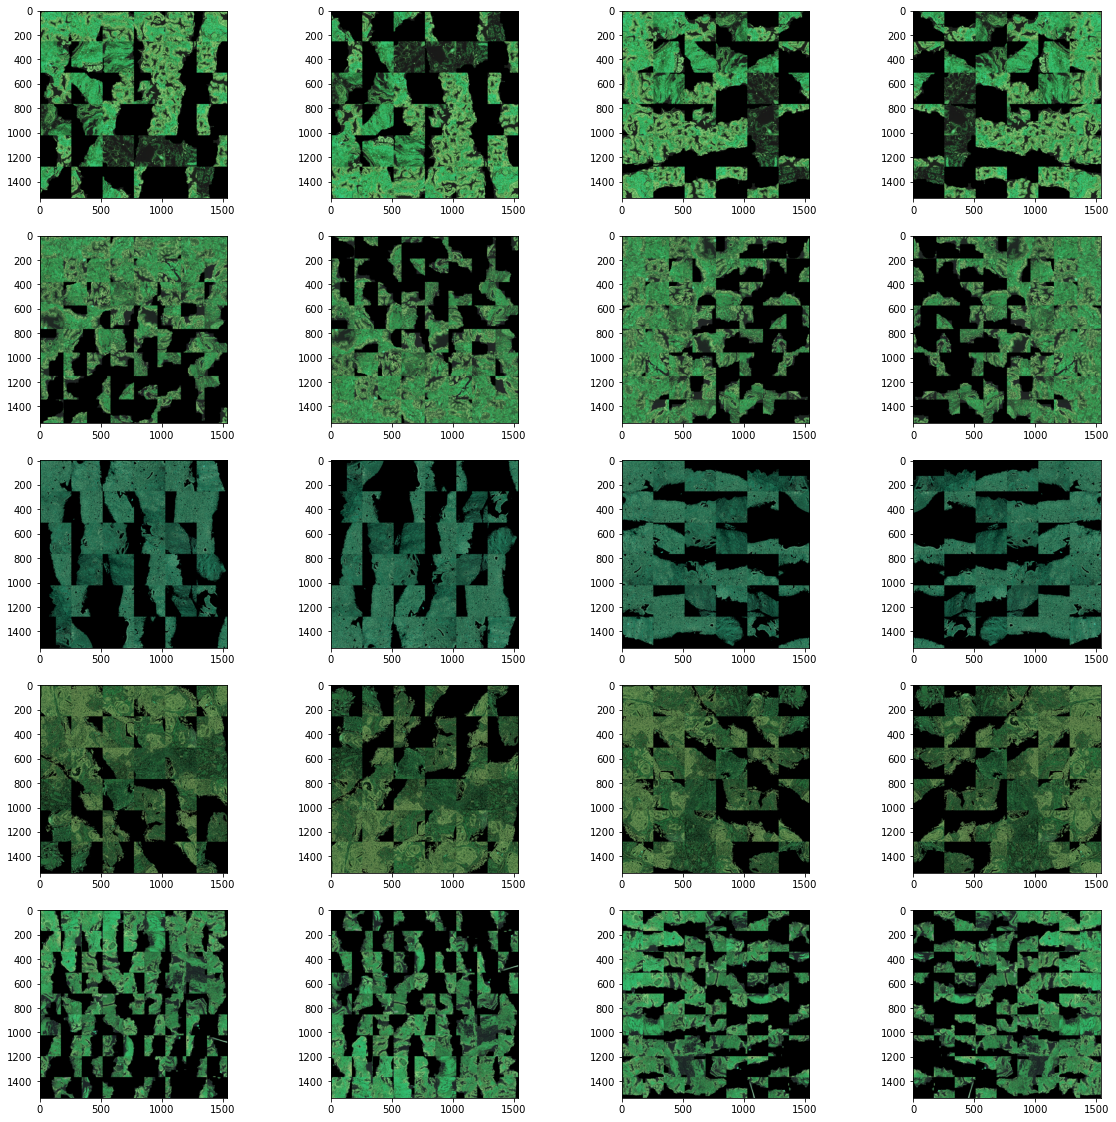

In [15]:
# test dataset
if not is_test:
    ds = MyTestDataset(df, shuffle_tiles=False)    
    
    # show samples
    fig, ax = plt.subplots(5, 4, figsize=(20, 20))
    for i in range(5):
        for j in range(4):
            x = ds[i]
            ax[i, j].imshow(x[j].permute(1, 2, 0)*0.5+0.5)
            
    del ds, fig, ax

# Model

In [16]:
sys.path.append('../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master/')

In [17]:
from efficientnet_pytorch import EfficientNet

class MyModel(nn.Module):
    def __init__(self, backbone=f'efficientnet-b{V}'):
        super().__init__()
        
        self.base = EfficientNet.from_name(backbone)
        self.fc = nn.Linear(self.base._fc.in_features, 1)
        self.base._fc = nn.Identity()
    
    def forward(self, x):
        x = self.base(x)
        x = self.fc(x)
        return x

In [18]:
if not is_test:
    model = MyModel()
    x = torch.randn(1, 3, 1536, 1536) # for b4, it can only accepts 512
    y = model(x)
    print(y.shape)
    
    del model, x, y
    torch.cuda.empty_cache()
    gc.collect()

torch.Size([1, 1])


In [19]:
torch.cuda.empty_cache()
gc.collect()

20

In [20]:
model = MyModel()
model = model.to(device)

ck = torch.load('../input/pandaefnb1regression/efnb1-other-1024-2000-0.85.pth', map_location=device)
model.load_state_dict(ck['state_dict'])
_ = model.eval()

# Train

In [21]:
def coef_round(pred):
    global ck
    coef = ck['coef']

    
    for i in range(len(pred)):
        if pred[i] < coef[0]:
            pred[i] = 0
        elif pred[i] >= coef[0] and pred[i] < coef[1]:
            pred[i] = 1
        elif pred[i] >= coef[1] and pred[i] < coef[2]:
            pred[i] = 2
        elif pred[i] >= coef[2] and pred[i] < coef[3]:
            pred[i] = 3
        elif pred[i] >= coef[3] and pred[i] < coef[4]:
            pred[i] = 4
        elif pred[i] >= coef[4]:
            pred[i] = 5
        
    return pred

In [22]:
# for later cohen
# have to put aside in case the df value got changed
if not is_test:
    y_trues = df.isup_grade.values

In [23]:
# why submission.csv not found
# put placeholder
# if following error happens, the score would be 0
if is_test:
    df['isup_grade'] = np.random.choice(6, len(df))
    df['isup_grade'] = df['isup_grade'].astype(np.int)
    df[['image_id', 'isup_grade']].to_csv('submission.csv', index=False)
    !ls
    display(pd.read_csv('submission.csv').head())

In [24]:
# mode = 0
test_ds = MyTestDataset(df, shuffle_tiles=False) 
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False) # for 4 tile mean

preds = []
with torch.no_grad():
    for idx, x in tqdm(enumerate(test_dl), total=len(test_dl)):
        x = x.squeeze().to(device, dtype=torch.float32) # (4, 3, 1536, 1536)

        y_preds = []
        for i in range(4):
            p = model(x[i].expand((1, 3, config.IMG_SIZE, config.IMG_SIZE)))
            y_preds.append(p)
        y_preds = np.mean(y_preds) # (4, 1) # get mean
        preds.append(y_preds) # add batch preds
    preds = np.array(preds)
        

preds = coef_round(preds)
df['isup_grade'] = preds
df['isup_grade'] = df['isup_grade'].astype(int)
    
    
# see cohen
if not is_test:
    score = cohen_kappa_score(y_trues, preds, weights='quadratic')
    print(score)


0.9126637554585153


In [25]:
# 0.9126 # 1536
# 0.6    # 1024

In [26]:
df[['image_id', 'isup_grade']].to_csv('submission.csv', index=False)
!ls
pd.read_csv('submission.csv').head()

__notebook__.ipynb  submission.csv


,image_id,isup_grade
0,0005f7aaab2800f6170c399693a96917,0
1,000920ad0b612851f8e01bcc880d9b3d,0
2,0018ae58b01bdadc8e347995b69f99aa,5
3,001c62abd11fa4b57bf7a6c603a11bb9,4
4,001d865e65ef5d2579c190a0e0350d8f,0
